## Overview

### Like Correspondence Analysis, but with Multiple

An extension of our notebook on [Correspondence Analysis](https://napsterinblue.github.io/notes/stats/techniques/correspondence/), *Multiple* Correspondence Analysis allows us to extend this methodology beyond a cross-tab of *two* different variables into arbitrarily-many.

For instance, a pretty canonical dataset used to describe this method ([see this paper](https://personal.utdallas.edu/~herve/Abdi-MCA2007-pretty.pdf)) is a taste profiling of various wines from different experts.

Like before, we start out with a dataset with `I` individuals as rows and `J` columns as features. However in this case, there are multiple responses per feature. A few things to point out in particular:

- Two different experts have the same feature. Expert 2 and 3 both have a `woody` column. MCA treats these columns separately, but if there's an underlying relationship between the two (as you might expect), the baricenters of the columns will wind up near one another
- There are also a couple features (`woody`, `vanillin`) that have more than a binary label
- We do a `.get_dummies()` call on each feature, however we don't want to use `drop_first=True`, like we would when fitting a model using dummy variables

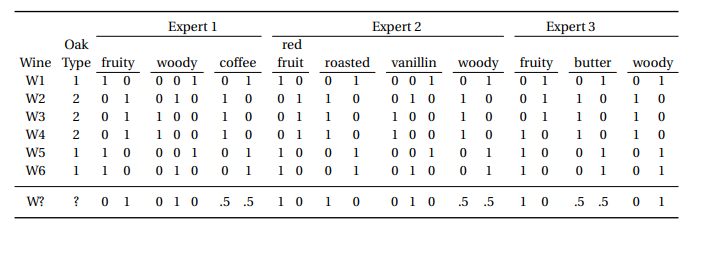

In [1]:
from IPython.display import Image

Image('images/mca_data.PNG')

Also worth noting that the table above is an *intermediate* table between "tall table with a column for each variable (not separated)" and "cross-tab used to do SVD".

Ultimately, we can do the similar "plot rows" or "plot columns" representation that we could do with CA, only this time with more levels.

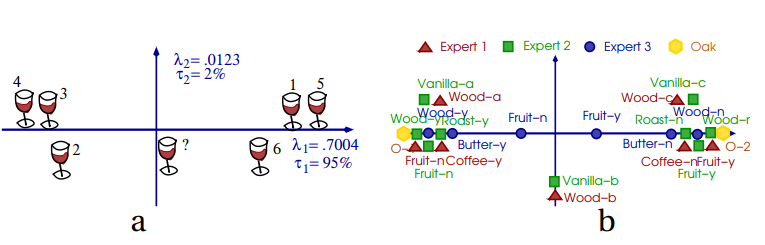

In [2]:
Image('images/mca_wines.PNG')

### A Bigger Example

[Of course Francois Husson has another helpful series on this topic](https://www.youtube.com/watch?v=gZ_7WWEVlTg).

In it, he explores a much, much larger dataset (`n=8403 >> 6`) encoding various lifestyle characteristics for a given population.

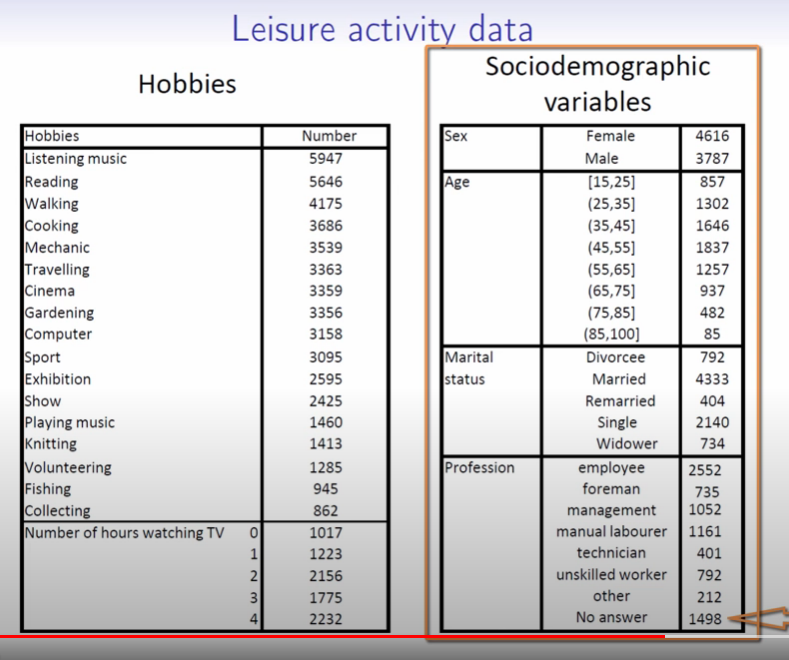

In [3]:
Image('images/mca_life_data.PNG')

He explores similar concepts as CA, including Inertia, weighting each record by the individual values, etc, etc.

But it gets particularly interesting when he fits to two axes and scatters each person's representation in this 2D space, *colored by their value for **one** feature*.

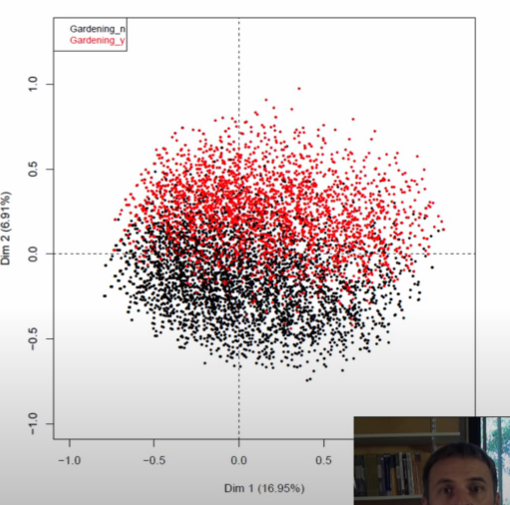

In [4]:
Image('images/mca_gardening_1.PNG')

This was still completely possible in CA, we just didn't have enough data for this pattern to show so starkly. Instead, what we got was a look at the barycenters for the given columns, which he then plots overtop of the scatter in two colored triangles.

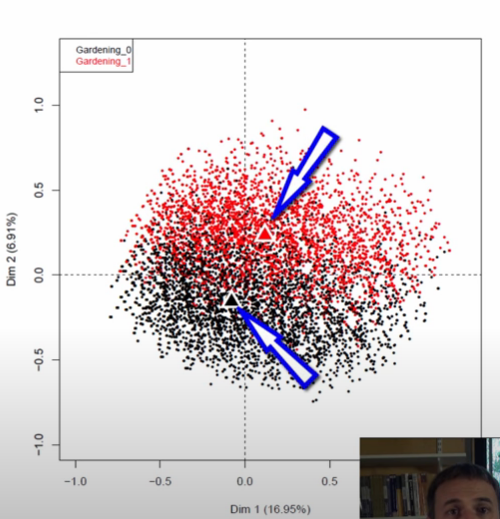

In [5]:
Image('images/mca_gardening_2.PNG')

Indeed doing this for all of the barycenters, he finds that a pattern emerges.

Recall that all of his data was organized not as a single `0/1` column, but as *two* `0/1` columns, eg:

```
cinema
   0
   1
   1
```
becomes

```
cinema_yes    cinema_no
    0             1
    1             0
    1             0
```

examining, he found that barycenters in black corresponded to the `_no`s and similarly, the reds to `_yes`.

You might be thinking "Well what does that have to do with the axis?" and that's where I'll remind you that the C in MCA stands for "correspondence." Or to put it another way, looking at this representation, we learn that people not doing one thing highly corresponds with them not doing another thing. Thus, **we can think of the first axis as an apathy continuum**

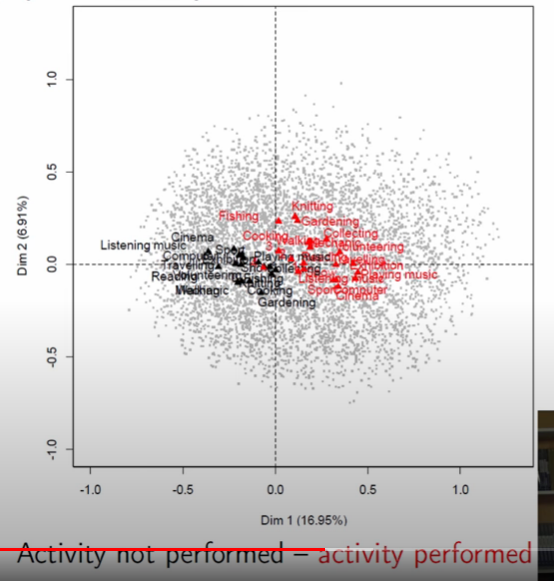

In [6]:
Image('images/mca_barycenters.PNG')

This is made even more obvious when he picks out four individuals at the fringe of this point cloud.

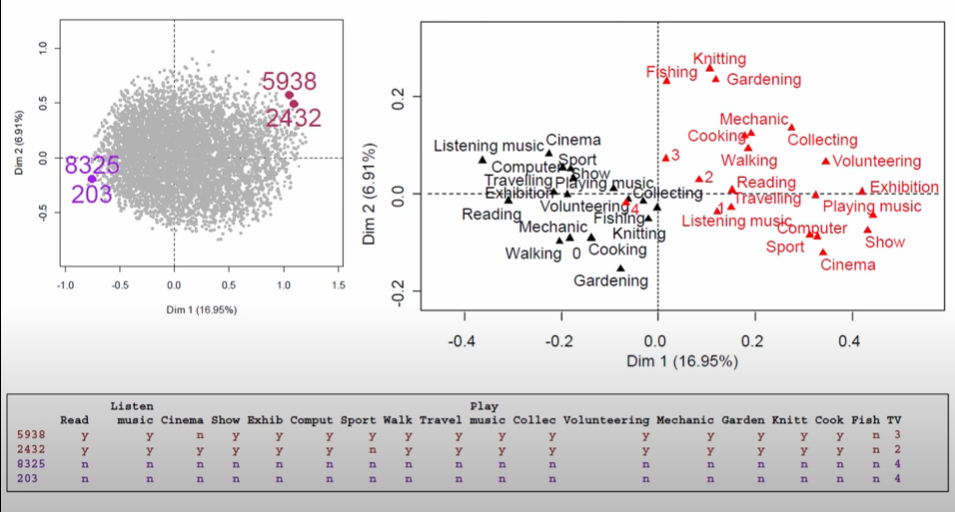

In [7]:
Image('images/mca_apathy.PNG')

Similarly, he looks at points on the opposite corners to see that the second axis is loosely associated with how youthful the hobbies are

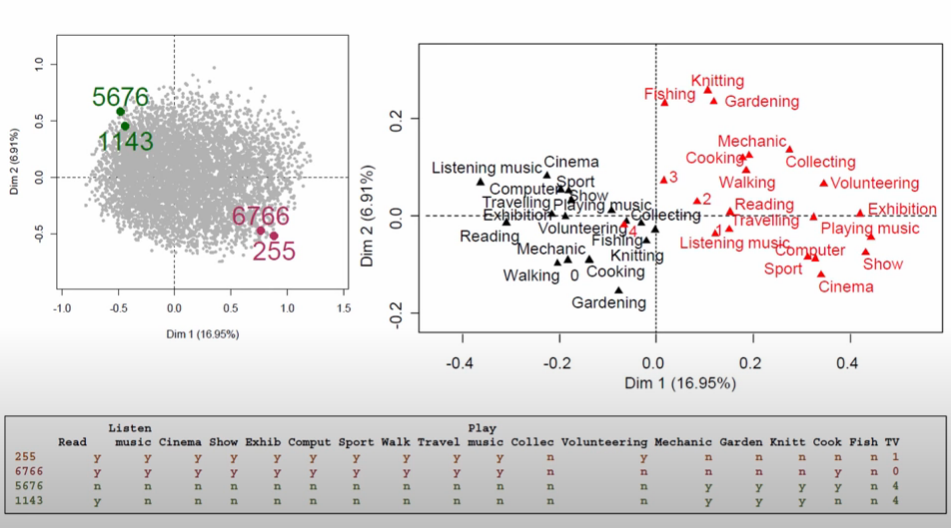

In [8]:
Image('images/mca_youth.PNG')

## In Python

To show how `prince` makes short work of `MCA`, we'll borrow the famous Titanic dataset from `seaborn`, as it's got a good amount of categorical variables.

In [9]:
%pylab inline

import pandas as pd
import prince
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


We load it up and drop any null values for `age`-- we want to use this in a second.

In [10]:
data = sns.load_dataset('titanic').dropna(subset=['age'])
data.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


Playing around with various bins, we find a few cuts that gives us a good separation in our data.

In [11]:
data['age_bin'] = pd.cut(data['age'],
                         [0, 18, 30, 45, 999])

data['age_bin'].value_counts().sort_index()

(0, 18]      139
(18, 30]     270
(30, 45]     202
(45, 999]    103
Name: age_bin, dtype: int64

And so we'll use this created feature, as well as a few other categorical features, to see if there's any underlying structure to our data.

In [12]:
df = data[['sex', 'embarked', 'class', 'age_bin']]

mca = prince.MCA()
mca.fit(df)

MCA(benzecri=False, check_input=True, copy=True, engine='auto', n_components=2,
    n_iter=10, random_state=None)

Like with CA, there's a nice `.plot_coordinates()` method that we can use to examine the structure of our loadings.

The first thing that stands out to me is the combination of green and blue dots for `Component 0`-- The continuum from low to high class passenger seems to correlate with whether or not that person was male.

Looking at `Component 1`, I was intrigued to see that the city that a person embarked in had such a spread (`Q`, `C`, `S`, in descending order). That is, until I saw that `age_bin` did as well.

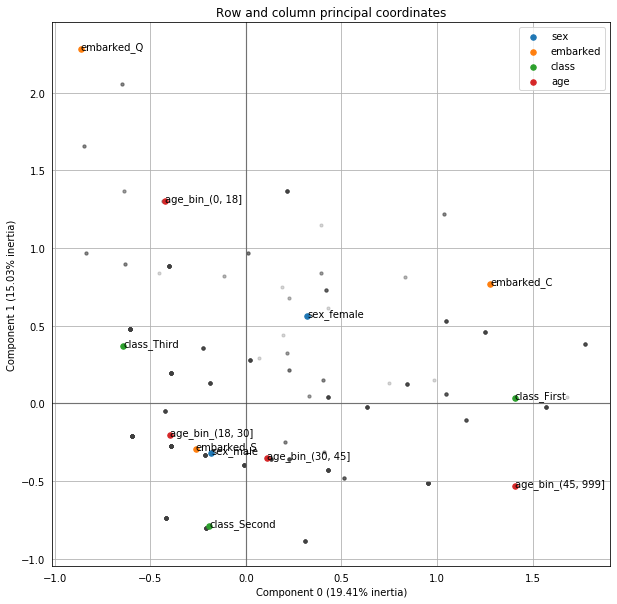

In [13]:
mca.plot_coordinates(df,
                     row_points_alpha=.2,
                     figsize=(10, 10),
                     show_column_labels=True
                    );

Indeed, looking at the distribution of ages by embark location from our original dataset, we can see that `Q` has the lowest median age, then `C`, then `S`, which is consistent with our ordering in the `Component 1`

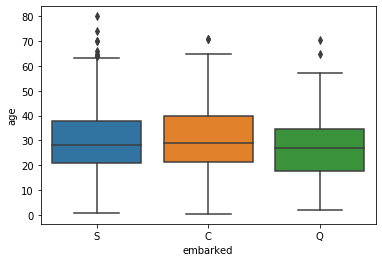

In [14]:
import seaborn as sns

sns.boxplot(data=data, x='embarked', y='age');

Neat!